Figures to compare classifiers with different weights

In [1]:
import torch
import glob
from os import path
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from loss_calibration.loss import StepLoss_weighted, BCELoss_weighted
from torch.distributions import Normal
from sbi.utils import BoxUniform


In [2]:
# load classifiers
files = sorted(glob.glob(path.join("./results/1d_classifier/", "2022-04-26*classifier.pt")))
print(f"Generating plots for:")
clfs = []

for file in files:
    print("- ", file)
    clfs.append(torch.load(file))

Generating plots for:
-  ./results/1d_classifier/2022-04-26T22_22_24_1d_classifier.pt
-  ./results/1d_classifier/2022-04-26T22_23_03_1d_classifier.pt
-  ./results/1d_classifier/2022-04-26T22_23_44_1d_classifier.pt
-  ./results/1d_classifier/2022-04-26T22_24_31_1d_classifier.pt
-  ./results/1d_classifier/2022-04-26T22_25_13_1d_classifier.pt
-  ./results/1d_classifier/2022-04-26T22_25_53_1d_classifier.pt
-  ./results/1d_classifier/2022-04-26T22_26_35_1d_classifier.pt
-  ./results/1d_classifier/2022-04-26T22_27_15_1d_classifier.pt
-  ./results/1d_classifier/2022-04-26T22_27_58_1d_classifier.pt
-  ./results/1d_classifier/2022-04-26T22_28_39_1d_classifier.pt
-  ./results/1d_classifier/2022-04-26T22_29_18_1d_classifier.pt


In [3]:
# load test data
threshold = clfs[0]._summary['treshold']
th_test = torch.load(path.join("./data/1d_classifier/", "th_test.pt"))[:1000]
x_test = torch.load(path.join("./data/1d_classifier/", "x_test.pt"))[:1000]
d_test = (th_test>threshold).float()[:1000]
N_test = th_test.shape[0]
N_test

1000

#### Decision Boundary dependent on costs

/Users/mgorecki/.virtualenvs/mthesis/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


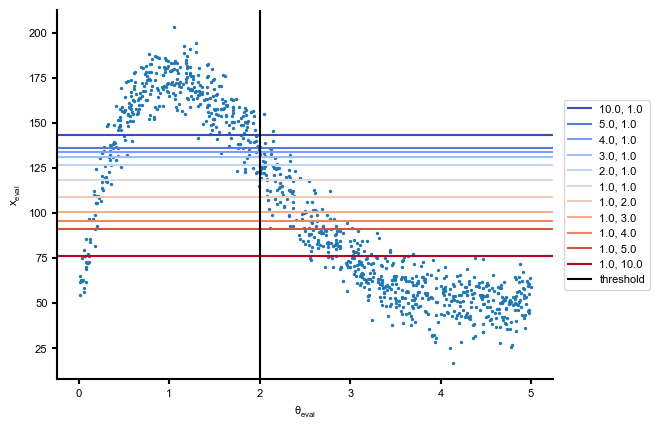

In [4]:
x_linspace = torch.linspace(10,210, 1000).unsqueeze(dim=1)
color_cycle = cycler(color = plt.cm.coolwarm(np.linspace(0, 1, len(clfs))))

decision_boundaries = []
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    plt.scatter(th_test, x_test, s=2)
    for clf, c in zip(clfs, color_cycle):
        preds_linspace = clf(x_linspace)
        idx = (torch.abs(preds_linspace - 0.5)).argmin()
        plt.axhline(x_linspace[idx], **c,label = ', '.join(map(str,clf._summary['weights'])))
        decision_boundaries.append(x_linspace[idx])
    plt.axvline(threshold, c = 'k',label = 'threshold')
    plt.xlabel(r'$\theta_{eval}$'); plt.ylabel(r'$x_{eval}$'); #plt.title('decision boundary for varying costs of misclassification')

    plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5),frameon=True)
    plt.savefig('results/1d_classifier/1D_clf_decision_boundaries.pdf')
    plt.show()

#### Predictions for varying costs

/Users/mgorecki/.virtualenvs/mthesis/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


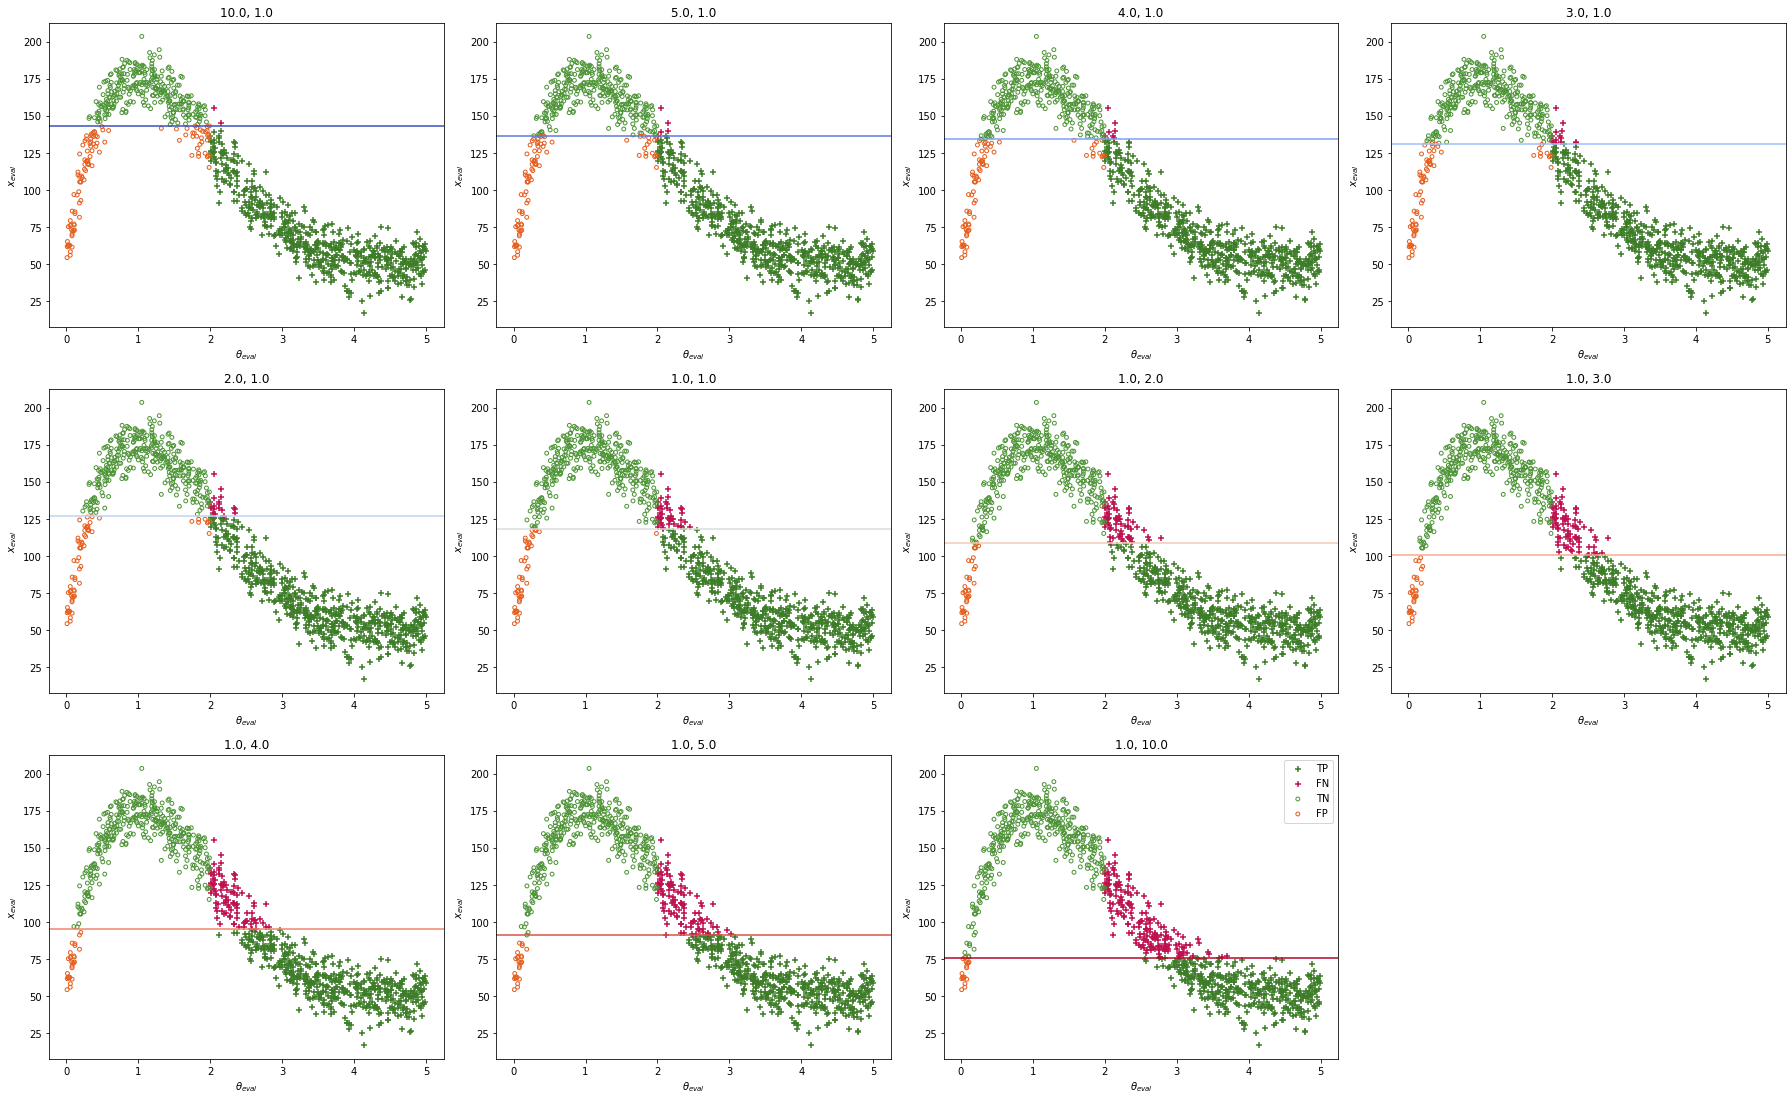

In [5]:
color_cycle = cycler(color = plt.cm.coolwarm(np.linspace(0, 1, len(clfs))))

#with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
plt.figure(figsize=(25,20))
for clf, c, i in zip(clfs, color_cycle, np.arange(len(clfs))):
    plt.subplot(4,4, i+1)

    preds_test_bin = (clf(x_test)>0.5).float()
    tn = torch.logical_and(preds_test_bin == 0, d_test == 0)
    tp = torch.logical_and(preds_test_bin == 1, d_test == 1)
    fn = torch.logical_and(preds_test_bin == 0, d_test == 1)
    fp = torch.logical_and(preds_test_bin == 1, d_test == 0)

    plt.scatter(th_test[tp], x_test[tp], c = '#3D7D28', marker= '+', label='TP', s = 30)
    plt.scatter(th_test[fn], x_test[fn], c = '#BF1150', marker= '+', label='FN', s = 30)
    plt.scatter(th_test[tn], x_test[tn], edgecolors = '#4D9436', marker= 'o', facecolors='none', label='TN', s = 15)
    plt.scatter(th_test[fp], x_test[fp], edgecolors = '#E55E1E', marker= 'o', facecolors='none', label='FP', s = 15)

    plt.axhline(decision_boundaries[i], **c)

    plt.xlabel(r'$\theta_{eval}$'); plt.ylabel(r'$x_{eval}$'); plt.title(', '.join(map(str,clf._summary['weights'])))
plt.tight_layout()
plt.legend()
plt.show()

#### Accuracy and FN/FP dependent on costs

In [6]:
tprs = []
tnrs = []
accs = []

for clf in clfs:
    preds_test_bin = (clf(x_test)>0.5).float()
    tn = torch.logical_and(preds_test_bin == 0, d_test == 0).sum()
    tp = torch.logical_and(preds_test_bin == 1, d_test == 1).sum()
    fn = torch.logical_and(preds_test_bin == 0, d_test == 1).sum()
    fp = torch.logical_and(preds_test_bin == 1, d_test == 0).sum()

    tprs.append(tp/(tp+fn))
    tnrs.append(tn/(tn+fp))
    accs.append((tp+tn)/N_test)

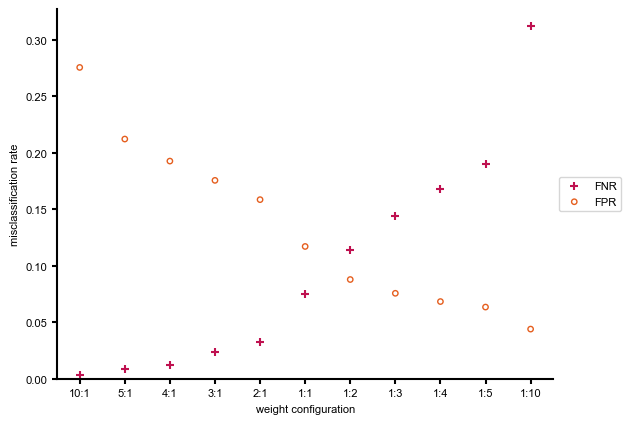

In [7]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    ax = plt.axes()
    plt.scatter(np.arange(len(clfs)), 1 - np.array(tprs), c = '#BF1150', marker= '+', label = 'FNR', s=30)
    plt.scatter(np.arange(len(clfs)), 1- np.array(tnrs), edgecolors = '#E55E1E', facecolors='none', marker= 'o', label = 'FPR', s=15)
    #plt.plot(np.arange(len(clfs)), accs, label = 'accuracy')
    ax.set_xticks(np.arange(len(clfs)))
    to_str = lambda lis: f'{str(int(lis[0]))}:{str(int(lis[1]))}'
    ax.set_xticklabels([to_str(clf._summary['weights']) for clf in clfs], )
    plt.xlabel('weight configuration'); plt.ylabel('misclassification rate')
    plt.ylim(bottom=0.0)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
    #plt.savefig('results/1d_classifier/1D_clf_fnr_fpr.pdf')
    plt.show()

### Comparison to sbi

#### Load Classifiers and Predictions

In [8]:
# load classifiers
files = sorted(glob.glob(path.join("./results/1d_classifier/", "2022-04-27T08*classifier.pt")))
files = [files[-1]] + files[:-1]
print(f"Generating plots for:")
clfs = []

for file in files:
    print("- ", file)
    clfs.append(torch.load(file))

Generating plots for:
-  ./results/1d_classifier/2022-04-27T08_42_56_1d_classifier.pt
-  ./results/1d_classifier/2022-04-27T08_38_10_1d_classifier.pt
-  ./results/1d_classifier/2022-04-27T08_38_25_1d_classifier.pt
-  ./results/1d_classifier/2022-04-27T08_38_44_1d_classifier.pt
-  ./results/1d_classifier/2022-04-27T08_39_07_1d_classifier.pt
-  ./results/1d_classifier/2022-04-27T08_39_31_1d_classifier.pt
-  ./results/1d_classifier/2022-04-27T08_39_58_1d_classifier.pt
-  ./results/1d_classifier/2022-04-27T08_40_28_1d_classifier.pt
-  ./results/1d_classifier/2022-04-27T08_41_01_1d_classifier.pt
-  ./results/1d_classifier/2022-04-27T08_41_36_1d_classifier.pt
-  ./results/1d_classifier/2022-04-27T08_42_13_1d_classifier.pt


In [ ]:
tprs = []
tnrs = []
accs = []
losses = []

for clf in clfs:
    preds_test_bin = (clf(x_test)>0.5).float()
    tn = torch.logical_and(preds_test_bin == 0, d_test == 0).sum()
    tp = torch.logical_and(preds_test_bin == 1, d_test == 1).sum()
    fn = torch.logical_and(preds_test_bin == 0, d_test == 1).sum()
    fp = torch.logical_and(preds_test_bin == 1, d_test == 0).sum()

    tprs.append(tp/(tp+fn))
    tnrs.append(tn/(tn+fp))
    accs.append((tp+tn)/N_test)
    weights = clf._summary['weights']
    T = clf._summary['treshold']
    bce_loss = BCELoss_weighted(weights, T)
    losses.append(bce_loss(preds_test_bin, d_test, th_test))
    


#### Load SBI Posteriors and Predictions

In [9]:
# load sbi posterior
files = sorted(glob.glob(path.join("./results/sbi/", "*.pt")))
print(f"Generating plots for:")
files = [files[-1]] + files[:-1]
posts = []

for file in files:
    print("- ", file)
    posts.append(torch.load(file))

Generating plots for:
-  ./results/sbi/2022-04-27T09_25_36_posterior_500.pt
-  ./results/sbi/2022-04-27T08_39_58_posterior_1000.pt
-  ./results/sbi/2022-04-27T08_41_14_posterior_5000.pt
-  ./results/sbi/2022-04-27T08_43_41_posterior_10000.pt
-  ./results/sbi/2022-04-27T08_46_00_posterior_15000.pt
-  ./results/sbi/2022-04-27T08_48_40_posterior_20000.pt
-  ./results/sbi/2022-04-27T08_52_35_posterior_25000.pt
-  ./results/sbi/2022-04-27T08_59_42_posterior_30000.pt
-  ./results/sbi/2022-04-27T09_06_07_posterior_35000.pt
-  ./results/sbi/2022-04-27T09_13_36_posterior_40000.pt
-  ./results/sbi/2022-04-27T09_18_34_posterior_45000.pt


In [10]:
def d(post, x_o, weights=[5.,1.], threshold = 2.0):
    loss = StepLoss_weighted(weights, threshold)
    thetas = torch.linspace(0,5, 1000)
    probs = post.log_prob(thetas.unsqueeze(dim=1), x = x_o).exp()
    # expected posterior loss
    loss_fn = (probs * loss(thetas, 0)).sum() 
    loss_fp = (probs * loss(thetas, 1)).sum()
    if loss_fn < loss_fp:
        return 0.
    else: 
        return 1.

In [11]:
nsim = [500, 1000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000]

In [ ]:
preds_sbi = []

for i, p in enumerate(posts): 
    print(i)
    preds = torch.as_tensor([d(p, x_o) for x_o in x_test]).unsqueeze(dim=1)
    preds_sbi.append(preds)

In [13]:
tprs_sbi = []
tnrs_sbi = []
accs_sbi = []
losses_sbi = []

for preds in preds_sbi:
    preds_test_bin = (clf(x_test)>0.5).float()
    tn_sbi = torch.logical_and(preds == 0, d_test == 0).sum()
    tp_sbi = torch.logical_and(preds == 1, d_test == 1).sum()
    fn_sbi = torch.logical_and(preds == 0, d_test == 1).sum()
    fp_sbi = torch.logical_and(preds == 1, d_test == 0).sum()

    tprs_sbi.append(tp_sbi/(tp_sbi+fn_sbi))
    tnrs_sbi.append(tn_sbi/(tn_sbi+fp_sbi))
    accs_sbi.append((tp_sbi+tn_sbi)/N_test)
    weights = [5.0,1.0]
    T = 2.0
    bce_loss = BCELoss_weighted(weights, T)
    losses_sbi.append(bce_loss(preds, d_test, th_test))
    


In [ ]:
# find decision boundary
# preds_linspace_sbi = torch.as_tensor([d(x) for x in x_linspace]).unsqueeze(dim=1)
# idx_sbi = torch.where(preds_linspace_sbi.diff(dim=0))

#### Ground Truth Posterior and Predictions

In [74]:
prior = BoxUniform([0.0], [5.0,])

def evaluate_prior(theta):
    return prior.log_prob(theta)
    
def evaluate_likelihood(theta, x): # p(x|theta)
    mean = 50 + 0.5*theta*(5-theta)**4
    noise_dist = Normal(mean, 10)
    return noise_dist.log_prob(x)

def evaluate_joint(theta, x):
    l = evaluate_likelihood(theta, x)
    p = evaluate_prior(theta).unsqueeze(1)
    return l + p

def normalize(values, lower, upper, resolution):
    sum_val = torch.sum(values)
    return sum_val * (upper - lower) / resolution

def gt_posterior(x, lower=0., upper=5., resolution=500):
    theta_grid = torch.linspace(lower, upper, resolution).unsqueeze(1)
    joint = evaluate_joint(theta_grid, x)
    joint_ = torch.exp(joint)
    norm_constant = normalize(joint_, lower, upper, resolution)
    norm_joint = joint_ / norm_constant
    return norm_joint

def gt_decision(x, lower=0., upper=5., resolution=500): 
    theta_grid = torch.linspace(lower, upper, resolution).unsqueeze(1)
    post = gt_posterior(x, lower, upper, resolution)
    loss = StepLoss_weighted(weights, threshold)
    # expected posterior loss
    loss_fn = (post * loss(theta_grid, 0) * (upper - lower)/resolution).sum() 
    loss_fp = (post * loss(theta_grid, 1) * (upper - lower)/resolution).sum()
    if loss_fn < loss_fp:
        return 0.
    else: 
        return 1.

In [79]:
gt_post = gt_posterior(torch.tensor([90]))

In [76]:
pred_gt_post = torch.as_tensor([gt_decision(x_o) for x_o in x_test]).unsqueeze(dim=1)
weights = [5.0,1.0]
T = 2.0
bce_loss = BCELoss_weighted(weights, T)
loss_gt_post = bce_loss(pred_gt_post, d_test, th_test)

#### Plots

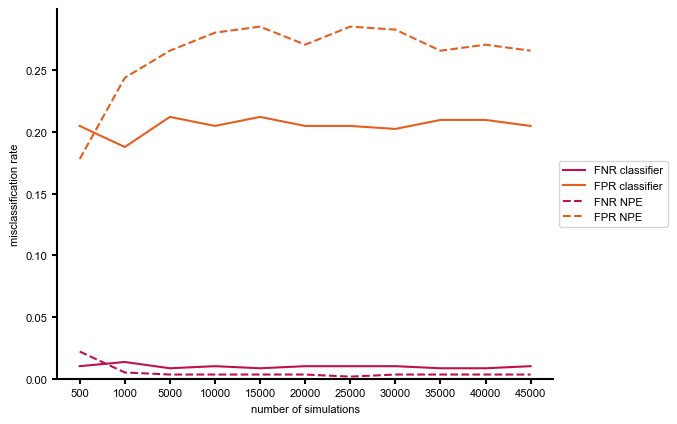

In [77]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    ax = plt.axes()
    plt.plot(np.arange(len(clfs)), 1 - np.array(tprs), c = '#BF1150', label = 'FNR classifier')
    plt.plot(np.arange(len(clfs)), 1- np.array(tnrs), c = '#E55E1E', label = 'FPR classifier')
    plt.plot(np.arange(len(posts)), 1 - np.array(tprs_sbi), c = '#BF1150', linestyle='dashed', label = 'FNR NPE')
    plt.plot(np.arange(len(posts)), 1- np.array(tnrs_sbi), c = '#E55E1E', linestyle='dashed', label = 'FPR NPE')
    #plt.plot(np.arange(len(clfs)), accs, label = 'accuracy')
    ax.set_xticks(np.arange(len(clfs)))
    to_str = lambda lis: f'{str(int(lis[0]))}:{str(int(lis[1]))}'
    ax.set_xticklabels(nsim)
    plt.xlabel('number of simulations'); plt.ylabel('misclassification rate')
    plt.ylim(bottom=0.0)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
    plt.savefig('results/1d_classifier/comparison_fnr_fpr.pdf')
    plt.show()

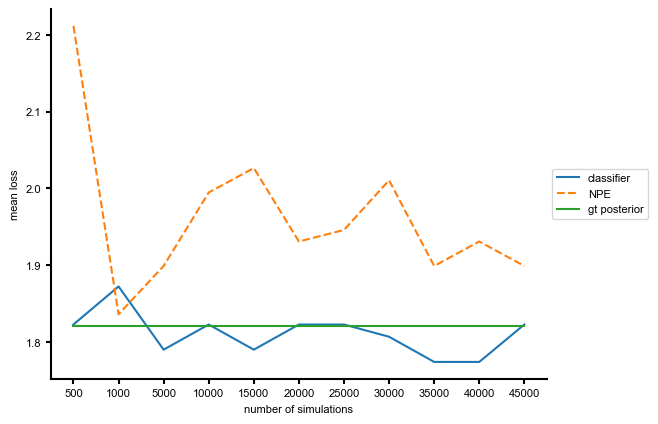

In [78]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    ax = plt.axes()
    plt.plot(np.arange(len(clfs)), losses, label = 'classifier')
    plt.plot(np.arange(len(posts)), losses_sbi, linestyle='dashed', label = 'NPE')
    plt.plot(loss_gt_post.repeat(len(nsim)), label='gt posterior')
    ax.set_xticks(np.arange(len(clfs)))
    to_str = lambda lis: f'{str(int(lis[0]))}:{str(int(lis[1]))}'
    ax.set_xticklabels(nsim)
    plt.xlabel('number of simulations'); plt.ylabel('mean loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
    plt.savefig('results/1d_classifier/comparison_loss.pdf')
    plt.show()